## Parsing the CSV File into Different Labels

The original data from the CSV file contained hundreds of email samples rated by native and non-native speakers, rated from negative to positive 12, per the abstract. The recorded means contain the average scores as multiple ratings were given for each sample. The normalized values go from around negative to positive 3.



In [1]:
import csv

# Gathering quartiles for normalized scores
csv_file_stats = open("RatingData - Sheet1.csv", "r")
csv_reader_stats = csv.reader(csv_file_stats)

scores_ns = []
scores_nns = []
next(csv_reader_stats, None)
for row in csv_reader_stats:
    scores_ns.append(float(row[4]))
    scores_nns.append(float(row[8]))
csv_file_stats.close()
scores_ns.sort()
scores_nns.sort()

partitions_ns = []
print("Quintiles for native speaker ratings:")
for i in range(6):
    p = scores_ns[int(i * (len(scores_ns) - 1)/5)]
    partitions_ns.append(p)
    print(p)

partitions_nns = []
print("Quintiles for non-native speaker ratings:")
for i in range(6):
    p = scores_nns[int(i * (len(scores_nns) - 1)/5)]
    partitions_nns.append(p)
    print(p)

Quintiles for native speaker ratings:
-2.325316667
-0.5821971667
-0.11386675
0.22728675
0.5890204
1.903856
Quintiles for non-native speaker ratings:
-2.3503525
-0.5637466667
-0.12146425
0.1667982857
0.60092275
2.578638


Scores by native speakers


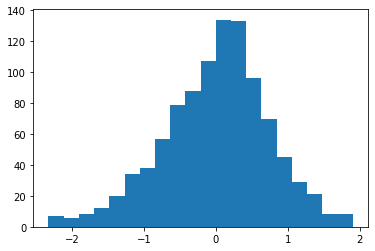

Scores by non-native speakers


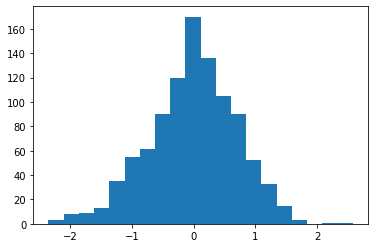

In [6]:
import matplotlib.pyplot as plt

print("Scores by native speakers")
plt.hist(scores_ns, 20)
plt.show()
print("Scores by non-native speakers")
plt.hist(scores_nns, 20)
plt.show()

### Labeling Schemes (Based on normalized scores)

Binary (0 or 1): less than zero is "impolite", "polite" otherwise

Strong Neutral (-1, 0, 1): adding a "neutral" tag for scores with an absolute value at most 0.25

Weak Neutral (-1, 0, 1): extending "neutral" tagging to scores with an absolute value at most 0.75

Intermediate (-2 to 2): set of five tags ["very impolite": score <= -1.5, "impolite": -1.5 < score < -0.5, "neutral": -0.5 <= score <= 0.5, "polite": 0.5 < score < 1.5, "very polite": score >= 1.5]

Partitions (-2 to 2): set of five tags like Intermediate, but using cutoffs defined by the quintiles

In [23]:
# Helper function for labeling, specs defined by labeling schemes
def getLabel(index, value, is_ns):
    if index == 0:
        # Binary labeling
        return 0 if value < 0 else 1
    elif index == 1:
        # Strong Neutral
        return 0 if abs(value) <= 0.25 else (-1 if value < 0 else 1)
    elif index == 2:
        # Weak Neutral
        return 0 if abs(value) <= 0.75 else (-1 if value < 0 else 1)
    elif index == 3:
        # Labeling with Intermediates
        if value <= -1.5:
            return -2
        elif value >= 1.5:
            return 2
        return 0 if abs(value) <= 0.5 else (-1 if value < 0 else 1)  
    else:
        # Labeling with Partitions
        partitions = partitions_ns if is_ns else partitions_nns
        if value <= partitions[1]:
            return -2
        elif value >= partitions[4]:
            return 2
        elif value <= partitions[2]:
            return -1
        elif value >= partitions[3]:
            return 1
        return 0 

In [24]:
csv_file = open("RatingData - Sheet1.csv", "r")
csv_reader = csv.reader(csv_file)

labels = ['ID', 'Message', 'NS', 'NNS']
filenames = ["BinaryLabeling.csv", "StrongNeutralLabeling.csv",
             "WeakNeutralLabeling.csv", "IntermediateLabeling.csv",
             "PartitionsLabeling.csv"]
fileobjs = [open("LabeledData/" + i, "w", newline='') for i in filenames]
writers = [csv.writer(i) for i in fileobjs]

# Gather statistics for each labeling scheme
counts_ns = [{} for i in filenames]
counts_nns = [{} for i in filenames]

In [25]:
for i in writers:
    i.writerow(labels)

bad_rows = 0
next(csv_reader, None)
for row in csv_reader:
    # Check for errors in comma division in csv
    if len(row) != 10:
        bad_rows += 1
    else:
        # Grabbing normalized scores from csv
        NS_score = float(row[4])
        NNS_score = float(row[8])
        
        # Performing labeling
        for i in range(len(filenames)):
            ns = getLabel(i, NS_score, True)
            nns = getLabel(i, NNS_score, False)
            writers[i].writerow([row[0], row[1], ns, nns])
            if ns in counts_ns[i]:
                counts_ns[i][ns] += 1
            else:
                counts_ns[i][ns] = 1
            if nns in counts_nns[i]:
                counts_nns[i][nns] += 1
            else:
                counts_nns[i][nns] = 1
csv_file.close()
for i in fileobjs:
    i.close()
print("Error rows:")
print(bad_rows)
print("\n\n")
for i in range(len(counts_ns)):
    print(filenames[i])
    print("Native speaker score frequencies:")
    print(counts_ns[i])
    print("Non-native speaker score frequencies:")
    print(counts_nns[i])
    print("\n")

Error rows:
0



BinaryLabeling.csv
Native speaker score frequencies:
{0: 456, 1: 544}
Non-native speaker score frequencies:
{0: 482, 1: 518}


StrongNeutralLabeling.csv
Native speaker score frequencies:
{-1: 332, 0: 278, 1: 390}
Non-native speaker score frequencies:
{0: 315, 1: 356, -1: 329}


WeakNeutralLabeling.csv
Native speaker score frequencies:
{0: 714, -1: 146, 1: 140}
Non-native speaker score frequencies:
{0: 712, -1: 150, 1: 138}


IntermediateLabeling.csv
Native speaker score frequencies:
{0: 536, -1: 195, -2: 30, 1: 225, 2: 14}
Non-native speaker score frequencies:
{0: 543, -1: 200, 1: 220, 2: 12, -2: 25}


PartitionsLabeling.csv
Native speaker score frequencies:
{-1: 200, -2: 200, 0: 199, 2: 201, 1: 200}
Non-native speaker score frequencies:
{-1: 200, 1: 200, -2: 200, 2: 201, 0: 199}


